<a href="https://colab.research.google.com/github/benedettads/Inferno/blob/main/Colab_BDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VERSIONE BENEDETTA DAL SASSO

19/10/2021

### **Obiettivo:**
#### *Verificare come cambiano i risultati per INFERNO e BCE nel caso in cui si cambiano le distribuzioni dei parametri di disturbo*

####**NOTE:**
- Si considerano come variabili di disturbo r e l sul background; si considera b (normalizzazione del background) fissato a 1000
- Nel training del modello usiamo l'espressione analitica dei parametri di disturbo nel campo shape_aux

- Quando aumentiamo l'incertezza su una sistematica stiamo rilassando il vincolo (la sistematica ha un vincolo più lasso, può variare di più)
- Durante il processo di inferenza (ossia quando calcoliamo la nlnL profilo) usiamo dei modelli per i disturbi che sono valutati a +-1 sigma (questo è specificato nella funzione get_syst_shapes) : si sta infatti usando la versione approssimata di inferno che prevede l'interpolazione di modelli
- Quando si hanno i modelli a +-1 sigma si usa come vincolo la N(0,1) così che la verosimiglianza viene punita quando le forme dei modelli sono cambiate troppo rispetto al valore nominale
- Durante l'inferenza pythorch_inferno utilizza un'interpolazione delle forme delle sistematiche shiftate : 0 è il valore nominale, e l'utente definisce le forme delle sistematiche a +-1 sigma (= N(0,1)) in base al vincolo inposto nel trainig 

Per aumentare l'incertezza sulle sistematiche:
1. Durante l'addestramento bisogna fornire una larghezza maggiore per il vincolo ausiliario 
2. Durante l'inferenza bisogna invece mantenere i vincoli ausiliari come N(0,1) per interpolare i modelli valutati a +-1 sgima dei valori dei disturbi e quindi fornire i valori di r e lambda corrispondenti a +- 1 sigma (= la loro sd) per fare l'interpolazione : imporre nell'inferenza N(0,1) significa usare, per il calcolo dei parametri di disturbo, l'interpolazione dei modelli valutati nei casi di shift di +-1 sigma dei parametri di disturbo.  
L'interpolazione consiste nella generazione dei dati con i valori shiftati di una sigma di r e lambda, poi si fa il fit dei modelli e si interpolano anche con quello ai valori nominali. 


Il valore nominale per r è 0 mentre per l è 3, nell'implementazione si considera fisso al valore nominale le sistematiche e si considera che c'è un valore additivo per ogni sistematica che può cambiare. Questo elemento additivo ha un valore nominale a 0, ma può variare nel fit di inferenza.
Inferno mira a diventare robusto verso questi cambiamenti. La sd delle misure ausiliarie forniscono un indicazione su quanto il valore additivo può variare. 

Quindi si presume che il set di dati nominale sia generato al valore nominale delle sistematiche e che questo sia fisso durante l'analisi.
C'è poi un valore additivo per ogni sistematica che può cambiare; questo valore additivo ha un valore nominale pari a zero, ma può variare nell'inferenza e INFERNO ha l'obiettivo di essere robusto a questi cambiamenti.
Quindi 
-  si generano dati nominali ai valori nominali (r_nom, l_nom) delle sistematiche 
-  sapendo che r ed l possono variare di sigma, si generano dati up e down a valori di (r_nom - sigma)  e (r_nom + sigma)
-  per non dover specificare in due posti diversi (una volta quando si inizializza la sistematica e un'altra quando si specificano le misure ausiliarie) del codice il valore nominale delle sistematiche, si stacca il valore medio dall'incertezza dovendo così soltanto specificarne l'incertezza nelle misure ausiliarie


Lessico: le misure ausiliarie sono le presunte distribuzioni delle sistematiche, ossia i vincoli









####**Setting**
-> b fissato a 1000

-> 100 epoche per il training

-> EarlyStopping(100)

-> learning rate lr=1e-5

In [ ]:
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install torch==1.9.0 fastcore==1.3.20 pytorch_inferno==0.2.2')


In [ ]:
from pytorch_inferno.data import get_paper_data
data, test = get_paper_data(200000, bs=2000, n_test=1000000)

In [ ]:
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.inferno import VariableSoftmax, PaperInferno
from torch import nn, optim
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))  

In [ ]:
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
from fastcore.all import partialler
from torch.distributions import Normal

init_net(net)
model_inf = ModelWrapper(net)

#Qui dobbiamo modificare solo l'incertezza delle sistematiche attraverso le misurazioni ausiliarie
#Here I have only to change the standard daviation oh shape_aux if I want to change the SD in the training
lt = LossTracker()
model_inf.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=None,
              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,0.2), Normal(0,0.5)], nonaux_b_norm=False),#nonaux_b_norm=True : b sono è completamente libero di variare senza nessun vincolo 
              lt,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])

1: Train=747.5122973632813 Valid=689.8398254394531
2: Train=626.3414730834961 Valid=592.4271496582031
3: Train=561.024762878418 Valid=546.2732720947265
4: Train=523.3826409912109 Valid=519.5908795166016
5: Train=503.5314950561523 Valid=506.95053833007813
6: Train=490.02136169433595 Valid=497.43670471191405
7: Train=481.70702575683595 Valid=489.27778564453126
8: Train=474.0816174316406 Valid=483.8320123291016
9: Train=466.7737255859375 Valid=476.9086633300781
10: Train=460.35343688964844 Valid=474.3999963378906
11: Train=458.73566345214846 Valid=469.3628234863281
12: Train=452.46510711669924 Valid=466.88830139160154
13: Train=448.4989547729492 Valid=465.1608599853516
14: Train=447.81776306152346 Valid=463.3411468505859
15: Train=445.05912353515623 Valid=460.21757934570314
16: Train=443.8179016113281 Valid=461.13109375
17: Train=440.10227844238284 Valid=456.5645001220703
18: Train=439.9337857055664 Valid=455.546953125
19: Train=438.79075317382814 Valid=450.90691955566405
20: Train=435.08

In [ ]:
net2 = nn.Sequential(nn.Linear(3,100),   nn.ReLU(),
                     nn.Linear(100,100), nn.ReLU(),
                     nn.Linear(100,1),   nn.Sigmoid())
init_net(net2)
model_bce = ModelWrapper(net2)
lt_bce = LossTracker()
model_bce.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=nn.BCELoss(),
              cbs=[lt_bce,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])

1: Train=0.45878676295280457 Valid=0.3855374795198441
2: Train=0.3548042955994606 Valid=0.3391540628671646
3: Train=0.3379118838906288 Valid=0.33840002298355104
4: Train=0.33680551141500475 Valid=0.33718329668045044
5: Train=0.3358254900574684 Valid=0.33610364973545076
6: Train=0.3355680736899376 Valid=0.33713547229766844
7: Train=0.33516321241855623 Valid=0.33470269203186037
8: Train=0.33440986812114715 Valid=0.33454579770565035
9: Train=0.33411985397338867 Valid=0.335253427028656
10: Train=0.3334991529583931 Valid=0.33413837492465975
11: Train=0.33355761766433717 Valid=0.33345029175281526
12: Train=0.3333873972296715 Valid=0.33345933198928834
13: Train=0.33296188473701477 Valid=0.33318851530551913
14: Train=0.3332230991125107 Valid=0.33531429290771486
15: Train=0.3331765401363373 Valid=0.3345398741960526
16: Train=0.332972449362278 Valid=0.3331909555196762
17: Train=0.333221532702446 Valid=0.33317675948143005
18: Train=0.33306042790412904 Valid=0.3333633130788803
19: Train=0.33280661

In [ ]:
from pytorch_inferno.inferno import InfernoPred
from pytorch_inferno.inference import bin_preds, get_shape, get_paper_syst_shapes, calc_profile
from pytorch_inferno.plotting import plot_likelihood, plot_preds
from pytorch_inferno.callback import PredHandler
import pandas as pd
import numpy as np
import torch
from torch import Tensor

In [ ]:
mu_scan = torch.linspace(20,80,61)
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

#Aggiunta degli argomenti r_vals e l_vals per cambiare i valori nominali, up e down delle sistematiche r e l
def compute_nll(model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    #plot_preds(df, bin_edges=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)

    #Settiamo i vincoli a essere N(0,1) ed elimino b_norm_aux per fissare b = 1000 (normalizzazione del background)
    nll = calc_profile(f_s_nom=f_s, **b_shapes, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll

In [ ]:
#Se si modifica la standard deviation nel training si può definire il cambiamento nell'inferenza qui

#I can change the values according to the SD that I already specified in the training 
r_vals = [-0.2, 0.,  0.2]   #corrisponde a [mu-sigma, mu, mu+sigma] della distribuzione N(0,0.2) che ha mu=0 e sigma=0.2
l_vals = [2.5, 3., 3.5]     #corrisponde a [mu-sigma, mu, mu+sigma] della distribuzione N(3,0.5) che ha mu=3 e sigma=0.5 che però è stata centrata in 0
nll_inf = compute_nll(model_inf, True ,  r_vals = r_vals, l_vals = l_vals)

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=2.5


Running: l=3.0


Running: l=3.5


In [ ]:
nll_bce = compute_nll(model_bce, False, r_vals = r_vals, l_vals = l_vals)

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=2.5


Running: l=3.0


Running: l=3.5


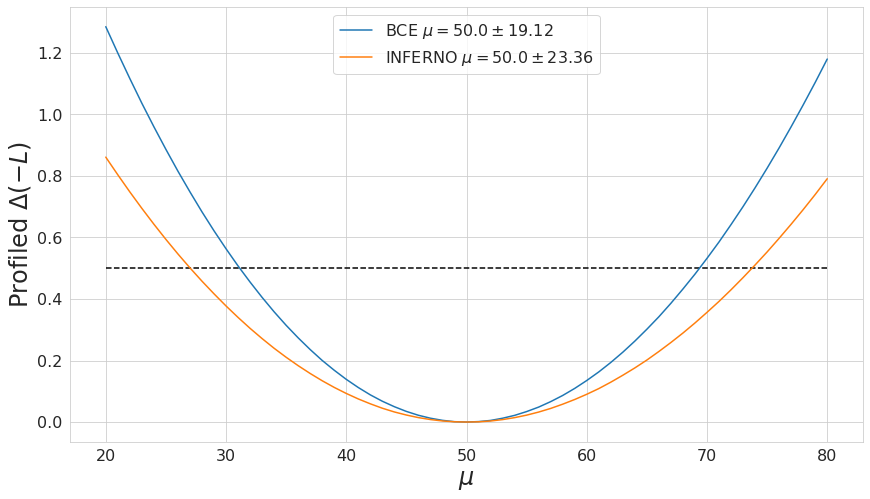

[19.121070327032513, 23.36009059771454]

In [ ]:
plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

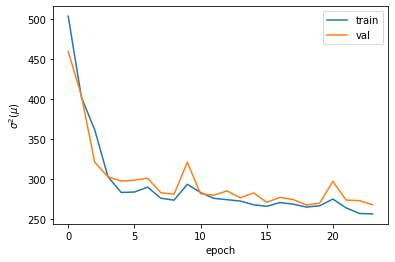

In [ ]:
##loss plot of INFERNO training
import matplotlib.pyplot as plt 
def plot_loss(lt):
    
    plt.plot(lt.losses["trn"], label="train")
    plt.plot(lt.losses["val"], label="val")
    plt.ylabel(r"$\sigma^2(\mu)$")
    plt.xlabel(r"epoch")
    plt.legend(loc="upper right")
    plt.show()
 
#init_net(net)
#model_inf = ModelWrapper(net)
#model_inf.fit(50, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
#              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,0.4), Normal(0,0.5)], nonaux_b_norm=False), #b = 1000 is fixed
#              lt,SaveBest('weights/best_ie.h5'),EarlyStopping(5)]) 
plot_loss(lt)


#EXAMPLE OF CHANGE

If I want to increase the SD of the parameter r from 0.2 to 0.4

1: Train=607.5135241699219 Valid=484.95776000976565
2: Train=434.11639221191405 Valid=424.7595324707031
3: Train=430.7319702148437 Valid=443.80534423828124
4: Train=402.191259765625 Valid=378.60606079101564
5: Train=372.62527206420896 Valid=383.35875610351565
6: Train=397.80609619140625 Valid=425.4195239257813
7: Train=378.69739547729495 Valid=384.57067443847654
8: Train=381.19031311035155 Valid=402.5055236816406
9: Train=419.8156571960449 Valid=398.6475274658203
Early stopping
Loading best model with loss 378.60606079101564


1: Train=0.4947359809279442 Valid=0.40215672969818117
2: Train=0.3680668559670448 Valid=0.34324453830718993
3: Train=0.3388481304049492 Valid=0.3378696721792221
4: Train=0.337101990878582 Valid=0.33677046597003935
5: Train=0.3364870294928551 Valid=0.3363984131813049
6: Train=0.3361715853214264 Valid=0.33601914465427396
7: Train=0.33601502418518064 Valid=0.3395011639595032
8: Train=0.33566042304039 Valid=0.33564892172813415
9: Train=0.3349917510151863 Valid=0.33487649381160733
10: Train=0.3347104489803314 Valid=0.33644587457180025
11: Train=0.334042592048645 Valid=0.33434501588344573
12: Train=0.33406166940927506 Valid=0.3346669363975525
13: Train=0.3338676530122757 Valid=0.33474631428718565
14: Train=0.33362269937992095 Valid=0.3375653326511383
15: Train=0.3337236055731773 Valid=0.33441957414150236
16: Train=0.3335173115134239 Valid=0.333419696688652
17: Train=0.33331392377614977 Valid=0.3344656950235367
18: Train=0.3335662516951561 Valid=0.33359721541404724
19: Train=0.333440693020820

Running: r=-0.4


Running: r=0.0


Running: r=0.4


Running: l=2.5


Running: l=3.0


Running: l=3.5


Running: r=-0.4


Running: r=0.0


Running: r=0.4


Running: l=2.5


Running: l=3.0


Running: l=3.5


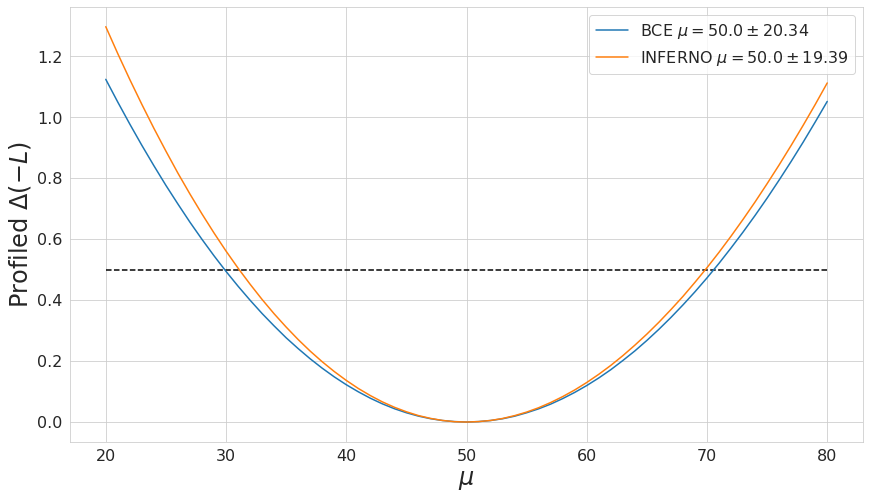

[20.344743642744767, 19.38877918585593]

In [ ]:
#Inferno model training
init_net(net)
model_inf = ModelWrapper(net)
lt = LossTracker()
model_inf.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=None,
              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,0.4), Normal(0,0.5)], nonaux_b_norm=False),#nonaux_b_norm=True : b sono è completamente libero di variare senza nessun vincolo 
              lt,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


#BCE model training
net2 = nn.Sequential(nn.Linear(3,100),   nn.ReLU(),
                     nn.Linear(100,100), nn.ReLU(),
                     nn.Linear(100,1),   nn.Sigmoid())
init_net(net2)
model_bce = ModelWrapper(net2)
model_bce.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=nn.BCELoss(),
              cbs=[LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(100)])

mu_scan = torch.linspace(20,80,61)
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
#The function compute_nll doesn't change

#The changes in inference
r_vals = [-0.4, 0.,  0.4]   
l_vals = [2.5, 3., 3.5]     
nll_inf = compute_nll(model_inf, True ,  r_vals = r_vals, l_vals = l_vals)
nll_bce = compute_nll(model_bce, False, r_vals = r_vals, l_vals = l_vals)

plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)


#**EXECUTION OF 10 RUN**

Si simulano 10 run per ciascuno dei casi presi in considerazione per le distribuzioni dei parametri di disturbo.

Si considerano le seguenti casistiche:
1. r∼N(0,0.2) e  λ∼N(3,0.5)
2. r∼N(0,0.5) e λ∼N(3,0.5)
3. r∼N(0,1) e λ∼N(3,0.5)
4. r∼N(0,0.2) e λ∼N(3,0.8)
5. r∼N(0,0.2) e λ∼N(3,1.4)







In [ ]:
#Code that I have to run only the firt time
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install torch==1.9.0 fastcore==1.3.20 pytorch_inferno==0.2.2')

from pytorch_inferno.data import get_paper_data
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.inferno import VariableSoftmax, PaperInferno
from torch import nn, optim
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
from fastcore.all import partialler
from torch.distributions import Normal
from pytorch_inferno.inferno import InfernoPred
from pytorch_inferno.inference import bin_preds, get_shape, get_paper_syst_shapes, calc_profile
from pytorch_inferno.plotting import plot_likelihood, plot_preds
from pytorch_inferno.callback import PredHandler
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import matplotlib.pyplot as plt 


def compute_nll(model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    #plot_preds(df, bin_edges=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)
    nll = calc_profile(f_s_nom=f_s, **b_shapes, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll



#Plot of loss
def plot_loss(lt):
    
    plt.plot(lt.losses["trn"], label="train")
    plt.plot(lt.losses["val"], label="val")
    plt.ylabel(r"$\sigma^2(\mu)$")
    plt.xlabel(r"epoch")
    plt.legend(loc="upper right")
    plt.show()



#Functions to fit models and calculate nll
def fit_bce( data, std_r, std_l ):

    net2 = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                     nn.Linear(100,100), nn.ReLU(),
                     nn.Linear(100,1),   nn.Sigmoid())
    init_net(net2)
    model_bce = ModelWrapper(net2)
    lt_bce = LossTracker()
    model_bce.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=nn.BCELoss(),
                  cbs=[lt_bce,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])
    plot_loss(lt_bce)
    r_vals = [0.-std_r, 0. , 0.+std_r]
    l_vals = [3.-std_l, 3. , 3.+std_l]
    print('r_vals', r_vals)
    print('l_vals', l_vals)
    nll_bce = compute_nll(model_bce, False , r_vals = r_vals, l_vals = l_vals)
    return nll_bce



def fit_inferno( data, std_r, std_l ):

    net = nn.Sequential(nn.Linear(3,100), nn.ReLU(),
                        nn.Linear(100,100),nn.ReLU(),
                        nn.Linear(100,10),
                        VariableSoftmax(0.1))
    init_net(net)
    model_inf = ModelWrapper(net)
    lt_inf = LossTracker()
    model_inf.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=None,
                  cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,std_r),
                  Normal(0,std_l)], nonaux_b_norm=False), lt_inf,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])
    plot_loss(lt_inf)
    r_vals = [0.-std_r, 0. , 0.+std_r]
    l_vals = [3.-std_l, 3. , 3.+std_l]
    print('r_vals', r_vals)
    print('l_vals', l_vals)
    nll_inf = compute_nll(model_inf, True , r_vals = r_vals, l_vals = l_vals)
    return nll_inf



In [ ]:
#Piece of code that I have run every time that I modify the standard deviations of r and lambda

#First case 
#  std_r = 0.2
#  std_l = 0.5
results_bce = []
results_inf = []
for i in range(1): 
  print('Run number:', i)
  data, test = get_paper_data(200000, bs=2000, n_test=1000000)  #generate a new sample of data
  mu_scan = torch.linspace(20,80,61)
  bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

  std_r = 0.2  #part to modify
  std_l = 0.5  #part to modify

  nll_inf = fit_inferno( data, std_r= std_r, std_l= std_l )
  nll_bce = fit_bce( data, std_r= std_r,std_l= std_l)

  std_bce, std_inf = plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

  results_bce.append(std_bce)
  results_inf.append(std_inf)



Run number: 0


1: Train=655.027861328125 Valid=655.4416296386719
2: Train=615.6175289916993 Valid=603.3631524658203
3: Train=576.5863284301757 Valid=577.2266870117187
4: Train=555.1173440551757 Valid=562.7005981445312
5: Train=535.4142361450196 Valid=546.4403375244141
6: Train=521.6870648193359 Valid=533.3439953613281
7: Train=504.74435272216795 Valid=520.1837664794922
8: Train=493.2913381958008 Valid=504.39713317871093
9: Train=483.1445758056641 Valid=500.66356201171874
10: Train=480.04553161621095 Valid=496.3020068359375
11: Train=474.942216796875 Valid=490.9298846435547
12: Train=466.98003326416017 Valid=487.1683642578125
13: Train=469.6495202636719 Valid=484.26832702636716
14: Train=464.2156463623047 Valid=481.1180407714844
15: Train=460.62431365966796 Valid=476.83293701171874
16: Train=455.1182019042969 Valid=473.53088806152346
17: Train=452.6354693603516 Valid=468.37449340820314
18: Train=447.31343627929687 Valid=465.16397583007813
19: Train=446.4579650878906 Valid=463.63493896484374
20: Train=

KeyboardInterrupt: ignored

Run number: 0


1: Train=621.0374691772461 Valid=643.4633972167969
Loading best model with loss 643.4633972167969


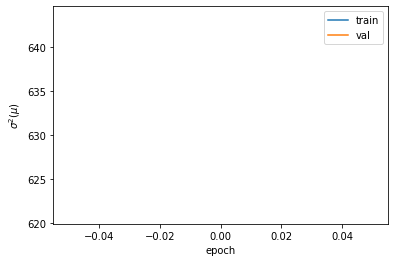

r_vals [-0.5, 0.0, 0.5]
l_vals [2.5, 3.0, 3.5]


Running: r=-0.5


Running: r=0.0


Running: r=0.5


Running: l=2.5


Running: l=3.0


Running: l=3.5


1: Train=1.4900356078147887 Valid=1.3476882696151733
Loading best model with loss 1.3476882696151733


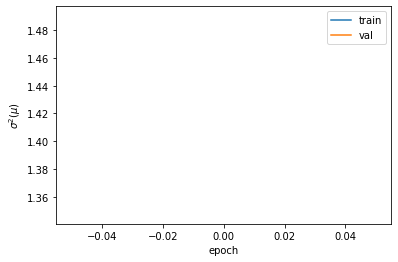

r_vals [-0.5, 0.0, 0.5]
l_vals [2.5, 3.0, 3.5]


Running: r=-0.5


Running: r=0.0


Running: r=0.5


Running: l=2.5


Running: l=3.0


Running: l=3.5


AttributeError: ignored

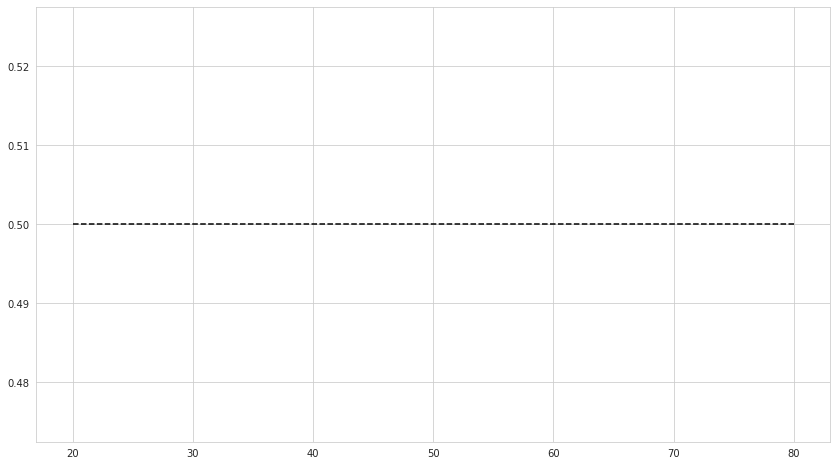

In [ ]:
#Second case
#  std_r = 0.5 
#  std_l = 0.5  
results_bce2 = []
results_inf2 = []
for i in range(10): 
  print('Run number:', i)
  data, test = get_paper_data(200000, bs=2000, n_test=1000000)  #generate a new sample of data
  mu_scan = torch.linspace(20,80,61)
  bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

  std_r = 0.5  #part to modify
  std_l = 0.5  #part to modify

  nll_inf = fit_inferno( data, std_r= std_r, std_l= std_l )
  nll_bce = fit_bce( data, std_r= std_r,std_l= std_l)

  std_bce, std_inf = plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

  results_bce2.append(std_bce)
  results_inf2.append(std_inf)

Run number: 0


1: Train=792.1723083496094 Valid=807.4473132324218
2: Train=741.3054983520508 Valid=755.7837426757812
3: Train=713.4346591186523 Valid=724.4596496582031
4: Train=688.7710507202148 Valid=698.2665228271485
5: Train=663.6478076171875 Valid=682.6771508789062
6: Train=646.1235940551758 Valid=656.4363671875
7: Train=628.3922952270508 Valid=638.9221014404297
8: Train=609.1746264648438 Valid=625.1699304199219
9: Train=596.3380331420899 Valid=604.948969116211
10: Train=573.855739440918 Valid=590.0363604736328
11: Train=549.786353149414 Valid=559.352578125
12: Train=529.9913107299805 Valid=540.8890893554687
13: Train=512.3917102050781 Valid=533.0660748291016
14: Train=504.24206970214846 Valid=519.6334167480469
15: Train=490.69450622558594 Valid=507.880771484375
16: Train=482.6674645996094 Valid=496.35699279785155
17: Train=472.07848876953125 Valid=487.87458435058596
18: Train=468.12372131347655 Valid=484.2920367431641
19: Train=464.0037924194336 Valid=483.1577355957031
20: Train=462.399642639160

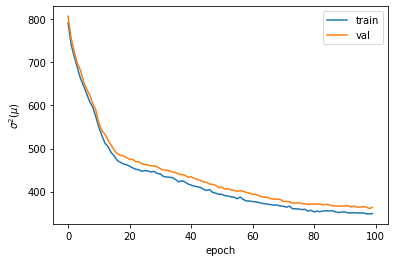

r_vals [-1.0, 0.0, 1.0]
l_vals [2.5, 3.0, 3.5]


Running: r=-1.0


Running: r=0.0


Running: r=1.0


Running: l=2.5


Running: l=3.0


Running: l=3.5


1: Train=1.7854891550540923 Valid=1.659054889678955
2: Train=1.5407218825817108 Valid=1.430059907436371
3: Train=1.3269783532619477 Valid=1.23220867395401
4: Train=1.1443217134475707 Valid=1.064827289581299
5: Train=0.9914343631267548 Valid=0.9257420980930329
6: Train=0.8655679261684418 Valid=0.81182537317276
7: Train=0.7615612506866455 Valid=0.7182715857028961
8: Train=0.6801411938667298 Valid=0.6484717059135438
9: Train=0.6202110105752945 Valid=0.5973535668849945
10: Train=0.5774739146232605 Valid=0.5620732855796814
11: Train=0.548468724489212 Valid=0.5381059515476226
12: Train=0.5283859765529633 Valid=0.5211033022403717
13: Train=0.5138897377252579 Valid=0.5085558098554611
14: Train=0.5029846370220185 Valid=0.4989062637090683
15: Train=0.49445925414562225 Valid=0.4912533062696457
16: Train=0.48760910242795946 Valid=0.4850310951471329
17: Train=0.4819668745994568 Valid=0.47984527707099917
18: Train=0.47720804810523987 Valid=0.4754289656877518
19: Train=0.47310497164726256 Valid=0.471

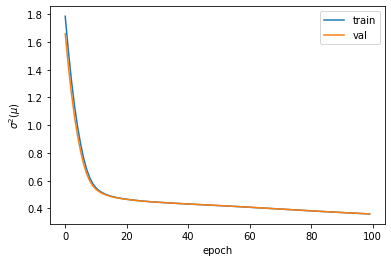

r_vals [-1.0, 0.0, 1.0]
l_vals [2.5, 3.0, 3.5]


Running: r=-1.0


Running: r=0.0


Running: r=1.0


Running: l=2.5


Running: l=3.0


Running: l=3.5


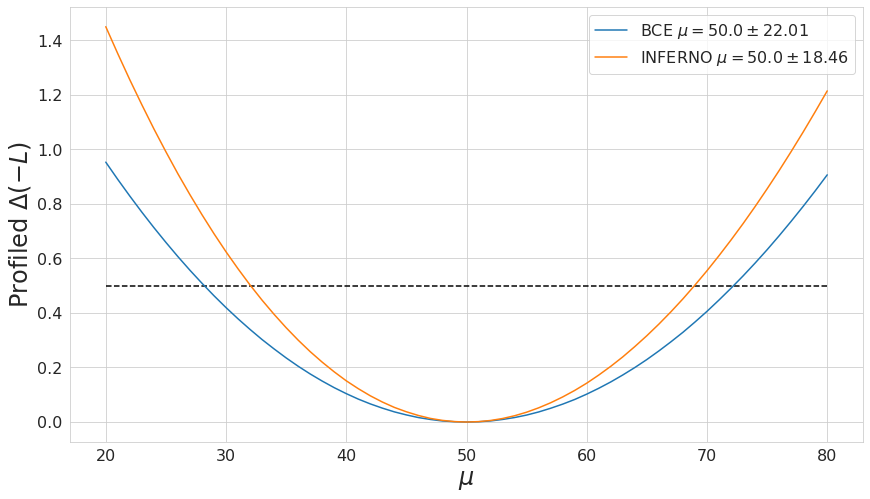

Run number: 1


1: Train=811.3482794189454 Valid=763.9537390136719
2: Train=698.5018890380859 Valid=668.9021020507812
3: Train=628.5428060913086 Valid=612.6969024658204
4: Train=587.828586730957 Valid=581.4178302001953
5: Train=562.7334262084961 Valid=571.5382055664063
6: Train=550.2464437866211 Valid=551.9959582519531
7: Train=535.9473803710938 Valid=542.4306134033203
8: Train=531.562766418457 Valid=539.0484002685547
9: Train=520.0495175170898 Valid=532.1979193115235
10: Train=521.2513595581055 Valid=528.1517785644531
11: Train=511.1825485229492 Valid=525.6219396972656
12: Train=506.48751251220705 Valid=518.0831646728516
13: Train=503.18179290771485 Valid=520.4629833984375
14: Train=500.1110623168945 Valid=514.5131091308593
15: Train=496.5272009277344 Valid=509.78771240234374
16: Train=496.5412844848633 Valid=508.6902758789063
17: Train=492.75293853759763 Valid=505.5916412353516
18: Train=481.63775329589845 Valid=504.9598388671875
19: Train=482.6524969482422 Valid=495.7080633544922
20: Train=480.0132

KeyboardInterrupt: ignored

In [ ]:
#Third case
#  std_r = 1
#  std_l = 0.5

results_bce4 = []
results_inf4 = []
for i in range(4): 
  print('Run number:', i)
  data, test = get_paper_data(200000, bs=2000, n_test=1000000)  #generate a new sample of data
  mu_scan = torch.linspace(20,80,61)
  bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

  std_r = 1
  std_l = 0.5

  nll_inf = fit_inferno( data, std_r= std_r, std_l= std_l )
  nll_bce = fit_bce( data, std_r= std_r,std_l= std_l)

  std_bce, std_inf = plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

  results_bce4.append(std_bce)
  results_inf4.append(std_inf)

In [ ]:
#Fourth case
#  std_r = 0.2 
#  std_l = 0.8  

results_bce4 = []
results_inf4 = []
for i in range(10): 
  print('Run number:', i)
  data, test = get_paper_data(200000, bs=2000, n_test=1000000)  #generate a new sample of data
  mu_scan = torch.linspace(20,80,61)
  bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

  std_r = 0.2 
  std_l = 0.8  

  nll_inf = fit_inferno( data, std_r= std_r, std_l= std_l )
  nll_bce = fit_bce( data, std_r= std_r,std_l= std_l)

  std_bce, std_inf = plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

  results_bce4.append(std_bce)
  results_inf4.append(std_inf)

Run number: 0


NameError: ignored

Run number: 0


1: Train=911.2710345458985 Valid=906.1562866210937
2: Train=880.8129028320312 Valid=876.3155407714844
3: Train=856.0412487792969 Valid=858.5870581054687
4: Train=837.412066040039 Valid=844.3453955078126
5: Train=818.959692993164 Valid=830.6206262207031
6: Train=808.9388342285156 Valid=817.1624328613282
7: Train=795.5281732177734 Valid=807.7967102050782
8: Train=787.7496130371094 Valid=795.4356958007812
9: Train=776.685322265625 Valid=788.5484240722657
10: Train=771.7337414550781 Valid=779.8007775878906
11: Train=761.8483862304688 Valid=769.5253259277343
12: Train=751.3121203613281 Valid=752.1449536132812
13: Train=733.5983404541016 Valid=731.6597058105468
14: Train=706.2200280761718 Valid=707.1418322753906
15: Train=673.3927746582032 Valid=670.6055932617187
16: Train=628.5326000976562 Valid=626.5245593261719
17: Train=577.2614907836914 Valid=559.1677209472656
18: Train=522.2163873291015 Valid=512.8890307617188
19: Train=495.8142498779297 Valid=492.99377502441405
20: Train=478.047283325

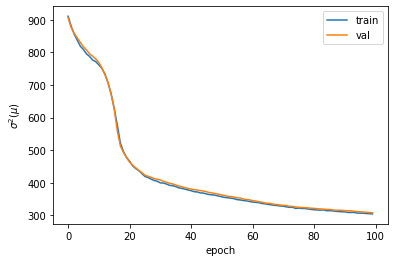

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


1: Train=1.5306273090839386 Valid=1.4158842635154725
2: Train=1.311052097082138 Valid=1.2101680159568786
3: Train=1.1198990154266357 Valid=1.0346962928771972
4: Train=0.9610195016860962 Valid=0.892894115447998
5: Train=0.835464870929718 Valid=0.783453825712204
6: Train=0.7405103242397308 Valid=0.7024257361888886
7: Train=0.6714281404018402 Valid=0.6442728757858276
8: Train=0.6224826776981354 Valid=0.6036603128910065
9: Train=0.5882495546340942 Valid=0.5750166726112366
10: Train=0.5638500344753266 Valid=0.554317831993103
11: Train=0.5458197319507598 Valid=0.538629549741745
12: Train=0.5319415473937988 Valid=0.5262832772731781
13: Train=0.5208435648679733 Valid=0.516259776353836
14: Train=0.5116775095462799 Valid=0.5078247880935669
15: Train=0.5038848954439163 Valid=0.500595532655716
16: Train=0.4971208414435387 Valid=0.49425043284893033
17: Train=0.4911585083603859 Valid=0.48861412465572357
18: Train=0.48583272367715835 Valid=0.48358231484889985
19: Train=0.4810436934232712 Valid=0.4790

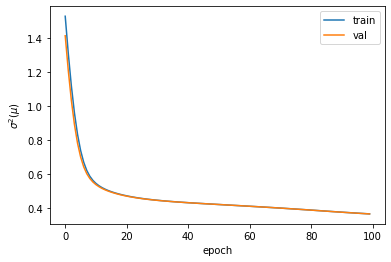

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


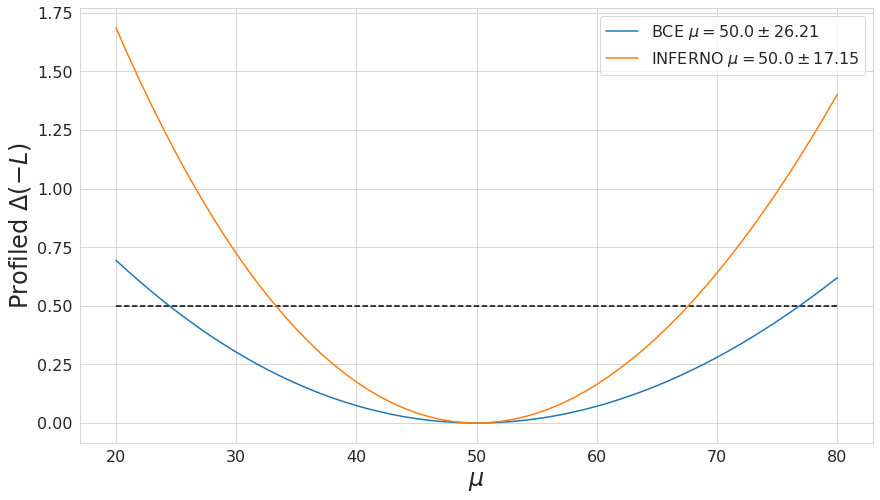

Run number: 1


1: Train=948.5702459716797 Valid=923.7974536132813
2: Train=887.5542895507813 Valid=852.9914367675781
3: Train=771.935796508789 Valid=706.8957458496094
4: Train=662.9442584228516 Valid=671.7042810058593
5: Train=644.2035620117188 Valid=658.7843481445312
6: Train=631.6704766845703 Valid=651.4382653808593
7: Train=620.5081884765625 Valid=643.0766162109375
8: Train=611.5523159790039 Valid=636.9175048828125
9: Train=600.2317526245117 Valid=628.7656384277344
10: Train=591.1243002319336 Valid=621.0032678222656
11: Train=586.70365234375 Valid=615.3159460449219
12: Train=579.6601196289063 Valid=613.9115393066406
13: Train=581.2915557861328 Valid=610.0678369140625
14: Train=572.4889440917968 Valid=600.9671728515625
15: Train=567.9317544555664 Valid=593.176674194336
16: Train=558.5809985351563 Valid=588.5995983886719
17: Train=558.0932385253906 Valid=583.8219665527344
18: Train=551.2973330688477 Valid=576.1452386474609
19: Train=540.4045123291015 Valid=570.3940881347656
20: Train=534.61100402832

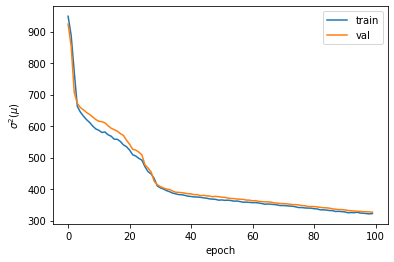

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


1: Train=0.8678849250078201 Valid=0.7842674589157105
2: Train=0.7255459159612656 Valid=0.6761598765850068
3: Train=0.6434201848506927 Valid=0.6158442568778991
4: Train=0.5970773202180862 Valid=0.5807749092578888
5: Train=0.5688624215126038 Valid=0.5581232225894928
6: Train=0.5498514777421951 Valid=0.5419967353343964
7: Train=0.5357436573505402 Valid=0.5294617319107056
8: Train=0.524415432214737 Valid=0.5191106736660004
9: Train=0.5149000942707062 Valid=0.5102500182390213
10: Train=0.5066524323821068 Valid=0.5024736076593399
11: Train=0.49939546912908556 Valid=0.4956201082468033
12: Train=0.49292311280965806 Valid=0.4894160717725754
13: Train=0.48706692904233934 Valid=0.48382325589656827
14: Train=0.4817560559511185 Valid=0.47871952891349795
15: Train=0.47691854685544965 Valid=0.47405811011791227
16: Train=0.4725108736753464 Valid=0.469826717376709
17: Train=0.46845361530780794 Valid=0.46584070563316343
18: Train=0.46458874762058255 Valid=0.46205641984939577
19: Train=0.4610201221704483

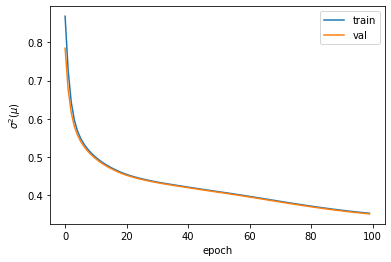

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


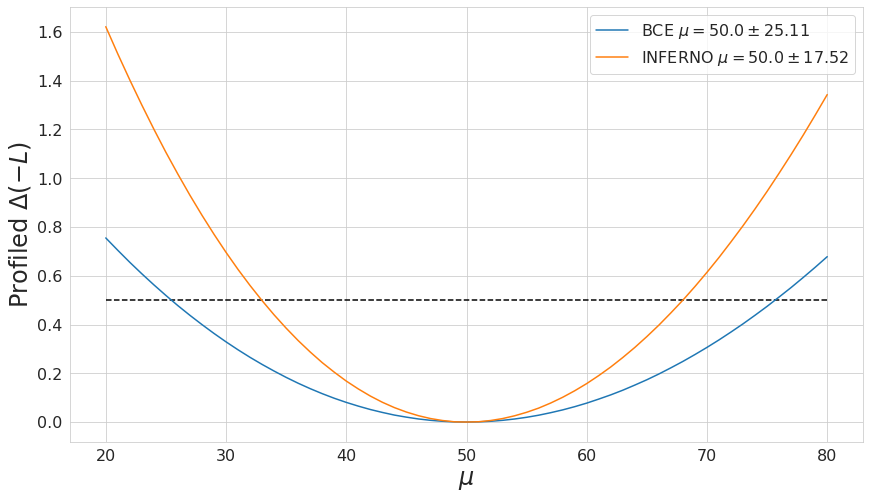

Run number: 2


1: Train=858.6916351318359 Valid=844.36841796875
2: Train=823.9091436767578 Valid=820.0057238769531
3: Train=804.7929553222656 Valid=793.8189343261719
4: Train=785.9173559570313 Valid=776.8673706054688
5: Train=768.3415466308594 Valid=769.6070935058593
6: Train=760.9668524169922 Valid=765.8702734375
7: Train=751.3121771240235 Valid=753.7796496582031
8: Train=747.0063873291016 Valid=747.6926745605468
9: Train=739.366181640625 Valid=744.6096850585938
10: Train=735.9706262207031 Valid=732.6757287597657
11: Train=726.941416015625 Valid=728.2402258300781
12: Train=719.2141967773438 Valid=715.7572912597657
13: Train=710.1540417480469 Valid=706.3593408203125
14: Train=698.6154620361328 Valid=696.8714440917969
15: Train=689.321420288086 Valid=688.132412109375
16: Train=679.3549633789063 Valid=681.5134008789063
17: Train=668.5228823852539 Valid=663.7398681640625
18: Train=658.3986581420899 Valid=648.5354846191407
19: Train=641.1257995605469 Valid=629.0821911621093
20: Train=623.6018807983398 Va

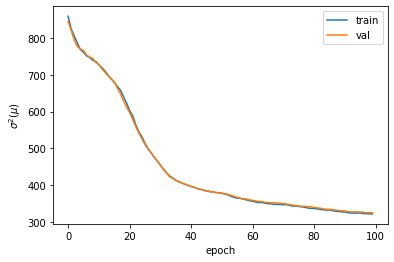

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


1: Train=0.9272553843259811 Valid=0.8240377855300903
2: Train=0.7473878532648086 Valid=0.6795816230773926
3: Train=0.6316548365354538 Valid=0.5908852005004883
4: Train=0.5640015691518784 Valid=0.5416509759426117
5: Train=0.5271929860115051 Valid=0.515042017698288
6: Train=0.5066977635025978 Valid=0.49940386712551116
7: Train=0.4940253993868828 Valid=0.4890873271226883
8: Train=0.4852494153380394 Valid=0.4815637081861496
9: Train=0.47860032856464385 Valid=0.4756445848941803
10: Train=0.4732495838403702 Valid=0.47079448521137235
11: Train=0.46879122316837313 Valid=0.46668368577957153
12: Train=0.46497907102108 Valid=0.46314014434814454
13: Train=0.46164762794971465 Valid=0.46000465989112854
14: Train=0.45868039458990095 Valid=0.4571888738870621
15: Train=0.455980918109417 Valid=0.4546248155832291
16: Train=0.45348999708890914 Valid=0.4522299599647522
17: Train=0.45114839762449266 Valid=0.44998409152030944
18: Train=0.44894019693136217 Valid=0.4478525000810623
19: Train=0.4468709868192673

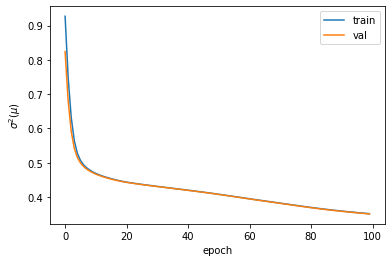

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


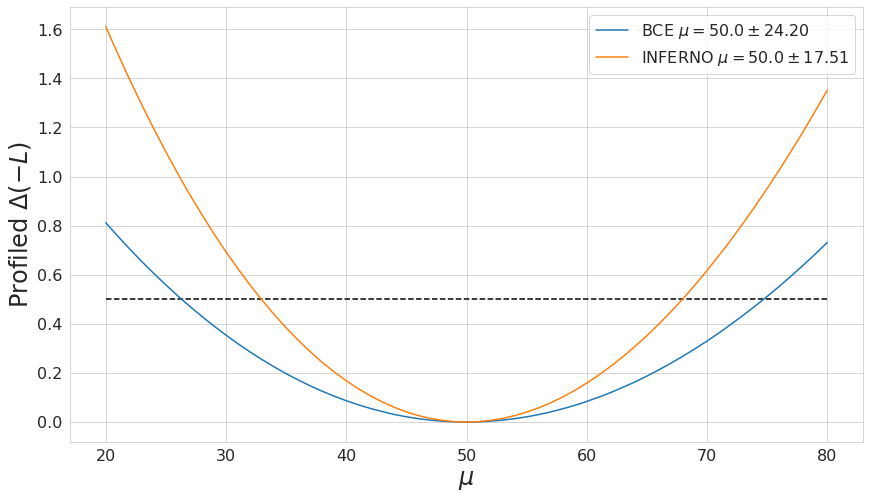

Run number: 3


1: Train=725.8251031494141 Valid=714.942412109375
2: Train=684.1827966308593 Valid=671.65361328125
3: Train=646.6533535766602 Valid=618.6067309570312
4: Train=595.0421612548828 Valid=576.6472955322265
5: Train=567.8810131835937 Valid=552.2822119140625
6: Train=549.6717895507812 Valid=530.3998168945312
7: Train=535.1617950439453 Valid=517.9102026367187
8: Train=518.4616320800782 Valid=500.92889404296875
9: Train=506.32625061035156 Valid=491.04180297851565
10: Train=494.18162109375 Valid=482.3986437988281
11: Train=487.8032525634766 Valid=477.44792907714844
12: Train=484.9267013549805 Valid=472.3284436035156
13: Train=473.40373565673826 Valid=462.95787170410154
14: Train=468.402688293457 Valid=457.1229766845703
15: Train=464.55688903808596 Valid=453.76902099609373
16: Train=458.72885986328123 Valid=450.772333984375
17: Train=454.59733795166017 Valid=445.32708251953125
18: Train=453.64268981933594 Valid=445.61176635742186
19: Train=450.54446014404294 Valid=443.82708557128905
20: Train=444

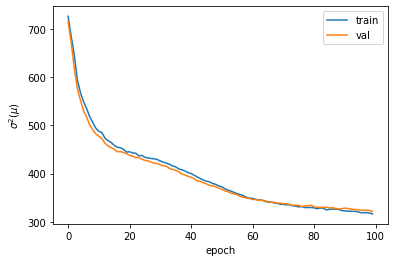

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


1: Train=0.8256400102376937 Valid=0.7759497678279876
2: Train=0.7380593883991241 Valid=0.7047464156150818
3: Train=0.6780211061239243 Valid=0.6545096862316132
4: Train=0.6344581180810929 Valid=0.61683886885643
5: Train=0.601229721903801 Valid=0.5875418150424957
6: Train=0.5750256782770157 Valid=0.5641743469238282
7: Train=0.5539286023378373 Valid=0.5451691126823426
8: Train=0.5367347246408463 Valid=0.5295962762832641
9: Train=0.5225335419178009 Valid=0.5166438901424408
10: Train=0.510668688416481 Valid=0.505817300081253
11: Train=0.5006902545690537 Valid=0.49661591947078704
12: Train=0.4921953171491623 Valid=0.48870446264743805
13: Train=0.48479662239551546 Valid=0.4817582470178604
14: Train=0.4783304789662361 Valid=0.4757193320989609
15: Train=0.47273035734891894 Valid=0.4705007982254028
16: Train=0.4678641748428345 Valid=0.46593679130077365
17: Train=0.46359647244215013 Valid=0.46188870310783386
18: Train=0.45981492251157763 Valid=0.45828031897544863
19: Train=0.45643849313259127 Val

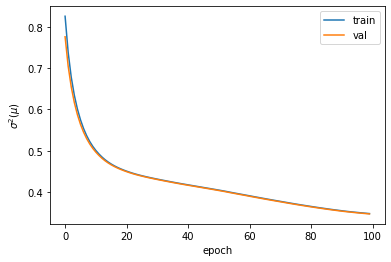

r_vals [-0.2, 0.0, 0.2]
l_vals [1.6, 3.0, 4.4]


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


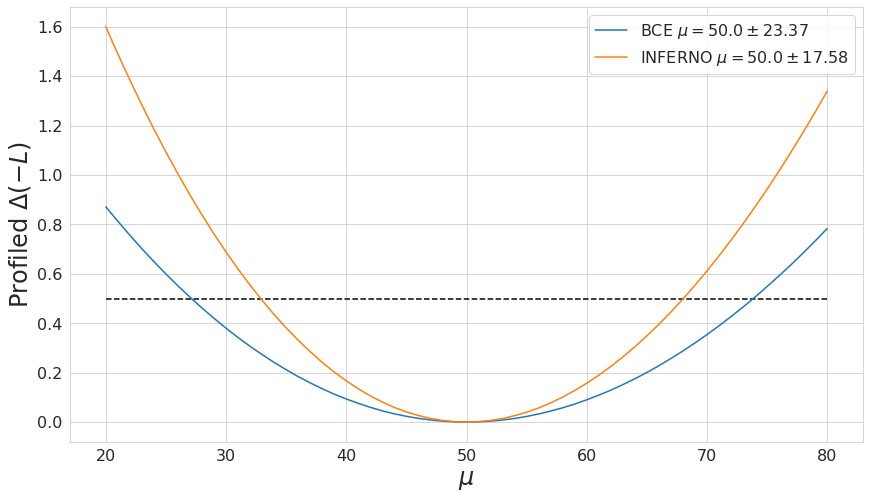

Run number: 4


1: Train=685.4756628417969 Valid=681.1948474121094
2: Train=645.4223129272461 Valid=640.2404962158203
3: Train=607.4422952270507 Valid=603.8130712890625
4: Train=574.5330130004883 Valid=577.4944769287109
5: Train=559.1507342529297 Valid=561.5608990478515
6: Train=543.2259545898437 Valid=547.8562969970703
7: Train=531.8227813720703 Valid=538.9002453613281
8: Train=528.5029483032226 Valid=532.9571020507813
9: Train=520.7386431884765 Valid=525.478203125
10: Train=516.7850668334961 Valid=522.8071166992188
11: Train=508.4368798828125 Valid=516.446997680664
12: Train=504.1587582397461 Valid=508.7813836669922
13: Train=500.3384997558594 Valid=505.7096173095703
14: Train=493.20715698242185 Valid=500.78057373046875
15: Train=490.39928161621094 Valid=491.70599975585935
16: Train=478.15630584716797 Valid=487.95155944824216


KeyboardInterrupt: ignored

In [ ]:
#Fifth case
#  std_r = 0.2
#  std_l = 1.4  

results_bce5 = []
results_inf5 = []
for i in range(10): 
  print('Run number:', i)
  data, test = get_paper_data(200000, bs=2000, n_test=1000000)  #generate a new sample of data
  mu_scan = torch.linspace(20,80,61)
  bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

  std_r = 0.2 
  std_l = 1.4  

  nll_inf = fit_inferno( data, std_r= std_r, std_l= std_l )
  nll_bce = fit_bce( data, std_r= std_r,std_l= std_l)

  std_bce, std_inf = plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

  results_bce5.append(std_bce)
  results_inf5.append(std_inf)

## Optimal values of nuisance parameters

Estrazione dei valori stimati dei parametri di disturbo per un certo valore di mu da INFERNO.

Nella prima cella si importano tutti i pacchetti necessari e si definiscono le funzioni utili.

Nella seconda cella si implementa il codice con i dati simulati. Questa cella sarà eseguita una volta per ciascuno dei casi analizzati.

In [ ]:
#First part : definition of useful functions
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install torch==1.9.0 fastcore==1.3.20 pytorch_inferno==0.2.2')

from pytorch_inferno.data import get_paper_data
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.inferno import VariableSoftmax, PaperInferno
from torch import nn, optim
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
from fastcore.all import partialler
from torch.distributions import Normal
from pytorch_inferno.inferno import InfernoPred
from pytorch_inferno.inference import bin_preds, get_shape, get_paper_syst_shapes, calc_profile
from pytorch_inferno.plotting import plot_likelihood, plot_preds
from pytorch_inferno.callback import PredHandler
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import matplotlib.pyplot as plt 
from pytorch_inferno.inference import calc_nll, calc_grad_hesse
from typing import Optional, Union, List, Dict
from torch.distributions import Distribution



def compute_nll(model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    #plot_preds(df, bin_edges=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)

    nll = calc_profile(f_s_nom=f_s, **b_shapes, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll

#Plot of loss
def plot_loss(lt):
    
    plt.plot(lt.losses["trn"], label="train")
    plt.plot(lt.losses["val"], label="val")
    plt.ylabel(r"$\sigma^2(\mu)$")
    plt.xlabel(r"epoch")
    plt.legend(loc="upper right")
    plt.show()

def newton_optimizer(mu_best:float, f_s_nom:Tensor, f_b_nom:Tensor, n_obs:int, mu_true:int,
                 f_s_up:Optional[Tensor]=None, f_s_dw:Optional[Tensor]=None,
                 f_b_up:Optional[Tensor]=None, f_b_dw:Optional[Tensor]=None,
                 shape_aux:Optional[List[Distribution]]=None,
                 s_norm_aux:Optional[List[Distribution]]=None, b_norm_aux:Optional[List[Distribution]]=None, nonaux_b_norm:bool=False,
                 n_steps:int=100, lr:float=0.1,  verbose:bool=True) -> Tensor:

    r'''Compute profile likelihoods for best mu value, optimising on full hessian.'''
    for f in [f_s_nom, f_s_up, f_s_dw, f_b_nom, f_b_up, f_b_dw]:  # Ensure correct dimensions
        if f is not None and len(f.shape) < 2: f.unsqueeze_(0)
    # Cases where nuisance only causes up or down variation
    if (f_s_up is None and f_s_dw is not None): f_s_up = torch.repeat_interleave(f_s_nom, repeats=len(f_s_dw), dim=0)
    if (f_s_dw is None and f_s_up is not None): f_s_dw = torch.repeat_interleave(f_s_nom, repeats=len(f_s_up), dim=0)
    if (f_b_up is None and f_b_dw is not None): f_b_up = torch.repeat_interleave(f_s_nom, repeats=len(f_b_dw), dim=0)
    if (f_b_dw is None and f_b_up is not None): f_b_dw = torch.repeat_interleave(f_s_nom, repeats=len(f_b_up), dim=0)
    if f_s_up is not None and f_b_up is not None and len(f_s_up) != len(f_b_up):
        raise ValueError("Shape variations for signal & background must have the same number of variations. \
                          Please enter the nominal templates for nuisances that only affect either signal of background.")
    # Norm uncertainties
    if s_norm_aux is None: s_norm_aux = []
    if b_norm_aux is None: b_norm_aux = []
    # Compute nuisance indeces
    n_alpha = np.max((len(f_b_up) if f_b_up is not None else 0, len(f_s_up) if f_s_up is not None else 0))
    shape_idxs = list(range(n_alpha))
    s_norm_idxs = list(range(n_alpha, n_alpha+len(s_norm_aux)))
    n_alpha += len(s_norm_aux)
    b_norm_idxs = list(range(n_alpha, n_alpha+len(b_norm_aux)+nonaux_b_norm))
    n_alpha += len(b_norm_aux)+nonaux_b_norm

    b_true = n_obs-mu_true

    get_nll = partialler(calc_nll, s_true=mu_true, b_true=b_true,
                        f_s_nom=f_s_nom, f_s_up=f_s_up, f_s_dw=f_s_dw,
                        f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw,
                        s_norm_aux=s_norm_aux, b_norm_aux=b_norm_aux, shape_aux=shape_aux)
    
    # List to store relevant info
    param_val = []
    # Initialize the parameters
    alpha = torch.zeros((n_alpha), requires_grad=True, device=f_b_nom.device)
    mu = torch.tensor(mu_best)#.to(f_b_nom.device)
    print("Mu", mu)
    for i in range(n_steps):  # Newton optimise nuisances
        nll = get_nll(shape_alpha=alpha[shape_idxs], mu=mu, s_norm_alpha=alpha[s_norm_idxs], b_norm_alpha=alpha[b_norm_idxs])
        #print("nll", nll)
        grad, hesse = calc_grad_hesse(nll, alpha, create_graph=False)
        #print("grad", grad)
        #print("hesse", hesse)
        # Step is learning rate * gradient * covariance matrix 
        cov = torch.inverse(hesse)
        step = lr*grad.detach()@cov
        #print("step", step)
        # Avoid too large steps
        step = torch.clamp(step, -100, 100)
        # Apply the step to the parameters
        alpha = alpha-step
        print("alpha", alpha)
        # Store the parameter infos
        param_val.append({ 'step':i, 'alpha':alpha.detach().cpu().numpy(), 'cov':cov.detach().cpu().numpy() })

    # Last nll evaluation
    nll = get_nll(shape_alpha=alpha[shape_idxs], mu=mu, s_norm_alpha=alpha[s_norm_idxs], b_norm_alpha=alpha[b_norm_idxs]).detach()
    return nll, param_val
 

def best_fit_values(mu_best:float, model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)
    nll, param_val = newton_optimizer(mu_best=mu_best, f_s_nom=f_s, **b_shapes, n_obs=1050, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll, param_val
    
def get_best_fit(nll, mu_scan):
    return mu_scan[np.argmin(nll)]





ModuleNotFoundError: ignored

1: Train=888.4409576416016 Valid=879.6999938964843
2: Train=851.0943804931641 Valid=843.186103515625
3: Train=810.1069549560547 Valid=787.05947265625
4: Train=757.1286529541015 Valid=731.6884838867187
5: Train=708.0533880615235 Valid=690.8386474609375
6: Train=670.9075628662109 Valid=658.7682861328125
7: Train=646.0682220458984 Valid=637.2512536621093
8: Train=627.0554656982422 Valid=625.6681726074219
9: Train=610.0833273315429 Valid=599.8097546386718
10: Train=586.1195114135742 Valid=586.0181469726563
11: Train=575.1942852783203 Valid=577.031083984375
12: Train=567.6507788085937 Valid=569.7530419921875
13: Train=562.0118182373047 Valid=566.6136840820312
14: Train=551.9110018920899 Valid=556.7777630615234
15: Train=544.4064895629883 Valid=549.1265759277344
16: Train=536.7062149047852 Valid=546.3074993896485
17: Train=530.958157043457 Valid=539.4419622802734
18: Train=523.3091876220703 Valid=533.3405224609374
19: Train=514.6018838500977 Valid=527.6602325439453
20: Train=510.373865356445

1: Train=0.7028856760263443 Valid=0.6699006414413452
2: Train=0.6438785058259964 Valid=0.6215531647205352
3: Train=0.6032761377096176 Valid=0.5878449606895447
4: Train=0.5751543164253234 Valid=0.5643930053710937
5: Train=0.5550577682256699 Valid=0.5470116651058197
6: Train=0.5395136678218841 Valid=0.5329701936244965
7: Train=0.5266731321811676 Valid=0.5210761225223541
8: Train=0.5156026813387871 Valid=0.5106939578056335
9: Train=0.5059500801563263 Valid=0.501618469953537
10: Train=0.4974663284420967 Valid=0.4936017245054245
11: Train=0.4899637067317963 Valid=0.4865024250745773
12: Train=0.48332346498966217 Valid=0.48023044526576997
13: Train=0.47742563992738724 Valid=0.4746364200115204
14: Train=0.472153981924057 Valid=0.4696166729927063
15: Train=0.46740559428930284 Valid=0.46509622514247895
16: Train=0.46310606837272644 Valid=0.4610264754295349
17: Train=0.4593628689646721 Valid=0.45753538608551025
18: Train=0.456115340590477 Valid=0.45446523249149323
19: Train=0.4532175800204277 Val

86: Train=0.3592949476838112 Valid=0.358831170797348
87: Train=0.358306028842926 Valid=0.35791336178779604
88: Train=0.3573749798536301 Valid=0.35698200166225436
89: Train=0.35648268908262254 Valid=0.35611715257167814
90: Train=0.35557774573564527 Valid=0.3552326518297195
91: Train=0.35471251875162124 Valid=0.35440183103084566
92: Train=0.3538863831758499 Valid=0.3536061131954193
93: Train=0.35308962762355806 Valid=0.35284158289432527
94: Train=0.35231387853622437 Valid=0.35208158850669863
95: Train=0.3515601941943169 Valid=0.35135853111743925
96: Train=0.3508487492799759 Valid=0.35065205454826354
97: Train=0.3501327410340309 Valid=0.3499785500764847
98: Train=0.3494403567910194 Valid=0.3493591272830963
99: Train=0.34880845367908475 Valid=0.34869876503944397
100: Train=0.3481722354888916 Valid=0.34811363697052
Loading best model with loss 0.34811363697052


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mu tensor(50.)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mu tensor(50.)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>)
alpha tensor([0., 0.], grad_fn=<SubBackward0>

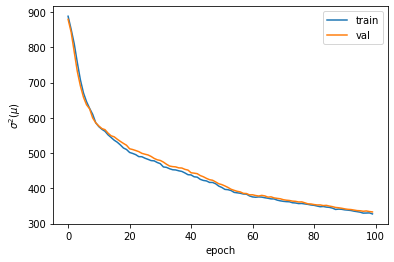

Loss function of BCE


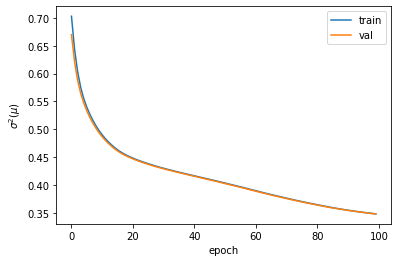

In [ ]:
#Second part : extraction of values from INFERNO and from BCE
data, test = get_paper_data(200000, bs=2000, n_test=1000000)

#Part to modify
std_r = 0.2
std_l = 1.4

#Inferno model training
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))  
init_net(net)
model_inf = ModelWrapper(net)
lt_inf = LossTracker()
model_inf.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=None, 
              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,std_r), Normal(0,std_l)], nonaux_b_norm=False),
              lt_inf,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


#BCE model training
net2 = nn.Sequential(nn.Linear(3,100),   nn.ReLU(),
                     nn.Linear(100,100), nn.ReLU(),
                     nn.Linear(100,1),   nn.Sigmoid())
init_net(net2)
lt_bce = LossTracker()
model_bce = ModelWrapper(net2)
model_bce.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-5), loss=nn.BCELoss(), 
              cbs=[lt_bce,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


mu_scan = torch.linspace(20,80,61)
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]


#The changes in inference
r_vals = [0. - std_r, 0.,  0. + std_r]    
l_vals = [3. - std_l, 3., 3. + std_l]     
nll_inf = compute_nll(model_inf, True ,  r_vals = r_vals, l_vals = l_vals)
nll_bce = compute_nll(model_bce, False, r_vals = r_vals, l_vals = l_vals)


# Get best fit value for mu
mu_best_inf = get_best_fit(nll_inf, mu_scan)
mu_best_bce = get_best_fit(nll_bce, mu_scan)

# Minimize NLL at best fit value
nll_i, param_val_i = best_fit_values(mu_best_inf, model_inf, True, r_vals=r_vals, l_vals =l_vals)
nll_b, param_val_b = best_fit_values(mu_best_bce, model_bce, False, r_vals=r_vals, l_vals =l_vals)
param_df_i = pd.DataFrame(param_val_i)
param_df_b = pd.DataFrame(param_val_b)

# Print cov matrix for last step of optimization
#Inferno
alpha_post_i = param_df_i.iloc[-1]["alpha"]
cov_post_i = param_df_i.iloc[-1]["cov"]
print('INFERNO')
print(alpha_post_i)
print(cov_post_i,'\n')

#Bce
alpha_post_b = param_df_b.iloc[-1]["alpha"]
cov_post_b = param_df_b.iloc[-1]["cov"]
print('BCE')
print(alpha_post_b)
print(cov_post_b,'\n')


#Plot loss
print('Loss function of INFERNO')
plot_loss(lt_inf)
print('Loss function of BCE')
plot_loss(lt_bce)



#  Update : optimal values of parameters


Ci sono pongono 2 obiettivi :
## Obiettivo 1 
Si vogliono utilizzare 5 campioni per fare 5 stime per ciascun caso con INFERNO e BCE delle matrici di var/cov dei parametri di disturbo r e lambda.
Ogni run di ciascun caso è esguito sullo stesso dataset, questo per rendere gli esiti maggiormente confrontabili in quanto escludono la possibile variabilità statistica dovuta al certo campione osservato. 

## Obiettivo 2
Si vuole valutare la variabilità dovuta all'ottimizzazione, sempre con entrambe le procedure, per ciascuno dei 5 casi analizzati.
Perciò con un certo campione di dati (che rimane immutato) si eseguono le procedure 5 volte, per ciascun caso, per avere una misura di variabilità sulla matrice di var/cov dei parametri di disturbo r e lambda dovuta unicamente alla procedura di ottimizzazione. 
Per rendere gli esiti tra i 5 casi maggiormente conforntabili, ossia calcolare le variabilità al netto dell'errore statistico dovuto al campione si utilizza un unico campione.

## Risoluzione obiettivo 1

In [ ]:
#First part : definition of useful functions
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install torch==1.9.0 fastcore==1.3.20 pytorch_inferno==0.2.2')

from pytorch_inferno.data import get_paper_data
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.inferno import VariableSoftmax, PaperInferno
from torch import nn, optim
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
from fastcore.all import partialler
from torch.distributions import Normal
from pytorch_inferno.inferno import InfernoPred
from pytorch_inferno.inference import bin_preds, get_shape, get_paper_syst_shapes, calc_profile
from pytorch_inferno.plotting import plot_likelihood, plot_preds
from pytorch_inferno.callback import PredHandler
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import matplotlib.pyplot as plt 
from pytorch_inferno.inference import calc_nll, calc_grad_hesse
from typing import Optional, Union, List, Dict
from torch.distributions import Distribution



def compute_nll(model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    #plot_preds(df, bin_edges=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)

    nll = calc_profile(f_s_nom=f_s, **b_shapes, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll

#Plot of loss
def plot_loss(lt):
    
    plt.plot(lt.losses["trn"], label="train")
    plt.plot(lt.losses["val"], label="val")
    plt.ylabel(r"$\sigma^2(\mu)$")
    plt.xlabel(r"epoch")
    plt.legend(loc="upper right")
    plt.show()


    
def newton_optimizer(mu_best:float, f_s_nom:Tensor, f_b_nom:Tensor, n_obs:int, mu_true:int,
                 f_s_up:Optional[Tensor]=None, f_s_dw:Optional[Tensor]=None,
                 f_b_up:Optional[Tensor]=None, f_b_dw:Optional[Tensor]=None,
                 shape_aux:Optional[List[Distribution]]=None,
                 s_norm_aux:Optional[List[Distribution]]=None, b_norm_aux:Optional[List[Distribution]]=None, nonaux_b_norm:bool=False,
                 n_steps:int=100, lr:float=0.1,  verbose:bool=True) -> Tensor:

    r'''Compute profile likelihoods for best mu value, optimising on full hessian.'''
    for f in [f_s_nom, f_s_up, f_s_dw, f_b_nom, f_b_up, f_b_dw]:  # Ensure correct dimensions
        if f is not None and len(f.shape) < 2: f.unsqueeze_(0)
    # Cases where nuisance only causes up xor down variation
    if (f_s_up is None and f_s_dw is not None): f_s_up = torch.repeat_interleave(f_s_nom, repeats=len(f_s_dw), dim=0)
    if (f_s_dw is None and f_s_up is not None): f_s_dw = torch.repeat_interleave(f_s_nom, repeats=len(f_s_up), dim=0)
    if (f_b_up is None and f_b_dw is not None): f_b_up = torch.repeat_interleave(f_s_nom, repeats=len(f_b_dw), dim=0)
    if (f_b_dw is None and f_b_up is not None): f_b_dw = torch.repeat_interleave(f_s_nom, repeats=len(f_b_up), dim=0)
    if f_s_up is not None and f_b_up is not None and len(f_s_up) != len(f_b_up):
        raise ValueError("Shape variations for signal & background must have the same number of variations. \
                          Please enter the nominal templates for nuisances that only affect either signal of background.")
    # Norm uncertainties
    if s_norm_aux is None: s_norm_aux = []
    if b_norm_aux is None: b_norm_aux = []
    # Compute nuisance indeces
    poi_idx = 0
    n_alpha = 1 + np.max((len(f_b_up) if f_b_up is not None else 0, len(f_s_up) if f_s_up is not None else 0))
    shape_idxs = list(range(1,n_alpha))
    print("shape_idxs", shape_idxs)
    s_norm_idxs = list(range(n_alpha, n_alpha+len(s_norm_aux)))
    n_alpha += len(s_norm_aux)
    b_norm_idxs = list(range(n_alpha, n_alpha+len(b_norm_aux)+nonaux_b_norm))
    n_alpha += len(b_norm_aux)+nonaux_b_norm

    b_true = n_obs-mu_true

    get_nll = partialler(calc_nll, s_true=mu_true, b_true=b_true,
                        f_s_nom=f_s_nom, f_s_up=f_s_up, f_s_dw=f_s_dw,
                        f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw,
                        s_norm_aux=s_norm_aux, b_norm_aux=b_norm_aux, shape_aux=shape_aux)
    
    # Initialize the parameters
    alpha = torch.zeros((n_alpha), requires_grad=True, device=f_b_nom.device)
    #mu = torch.tensor(mu_best)#.to(f_b_nom.device)
    with torch.no_grad(): alpha[poi_idx] = mu_best

    print("alpha", alpha)

    # List to store relevant info
    param_val = []

    # print("Mu", mu)
    for i in range(n_steps):  # Newton optimise nuisances
        nll = get_nll(shape_alpha=alpha[shape_idxs], mu=alpha[poi_idx], s_norm_alpha=alpha[s_norm_idxs], b_norm_alpha=alpha[b_norm_idxs])
        #print("nll", nll)
        grad, hesse = calc_grad_hesse(nll, alpha, create_graph=False)
        #print("grad", grad)
        #print("hesse", hesse)
        # Step is learning rate * gradient * covariance matrix 
        cov = torch.inverse(hesse)
        step = lr*grad.detach()@cov
        #print("step", step)
        # Avoid too large steps
        step = torch.clamp(step, -100, 100)
        # Apply the step to the parameters
        alpha = alpha-step
        print("alpha", alpha)
        # Store the parameter infos
        param_val.append({ 'step':i, 'alpha':alpha.detach().numpy(), 'cov':cov.detach().numpy() })

    # Last nll evaluation
    nll = get_nll(shape_alpha=alpha[shape_idxs], mu=alpha[poi_idx], s_norm_alpha=alpha[s_norm_idxs], b_norm_alpha=alpha[b_norm_idxs]).detach()
    return nll, param_val 

def best_fit_values(mu_best:float, model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)
    nll, param_val = newton_optimizer(mu_best=mu_best, f_s_nom=f_s, **b_shapes, n_obs=1050, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll, param_val
    
def get_best_fit(nll, mu_scan):
    return mu_scan[np.argmin(nll)]

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [ ]:
#Creazione dataset c_i con cui eseguo l'i-esimo run per ogni caso 
data, test = get_paper_data(200000, bs=2000, n_test=1000000)


1: Train=547.1688259887695 Valid=510.67502563476563
2: Train=483.8181182861328 Valid=458.039560546875
3: Train=448.00190399169924 Valid=436.56315185546873
4: Train=433.0596618652344 Valid=417.6026306152344
5: Train=423.9770874023437 Valid=408.66016052246096
6: Train=405.7158392333984 Valid=394.0613763427734
7: Train=388.57039764404294 Valid=379.57750610351565
8: Train=379.4150241088867 Valid=366.96911560058595
9: Train=365.14234252929685 Valid=355.86329345703126
10: Train=356.8951406860352 Valid=344.98053466796875
11: Train=344.1689630126953 Valid=342.60781005859377
12: Train=339.36801361083985 Valid=331.9372882080078
13: Train=334.3962484741211 Valid=332.6978771972656
14: Train=331.0565510559082 Valid=321.6424102783203
15: Train=324.57830322265625 Valid=318.2468914794922
16: Train=321.95408096313474 Valid=316.08246826171876
17: Train=315.55144256591797 Valid=312.0689227294922
18: Train=314.0310697937012 Valid=309.19648376464846
19: Train=309.536450958252 Valid=309.5940270996094
20: Tr

1: Train=0.6433344399929046 Valid=0.5191835975646972
2: Train=0.4817184630036354 Valid=0.4558804589509964
3: Train=0.4462498939037323 Valid=0.4358587634563446
4: Train=0.43190907627344133 Valid=0.4243213653564453
5: Train=0.42152311742305754 Valid=0.4144746720790863
6: Train=0.41211981743574144 Valid=0.405366495847702
7: Train=0.4031142124533653 Valid=0.39647894382476806
8: Train=0.39415271490812304 Valid=0.38729643762111665
9: Train=0.38492327332496645 Valid=0.37796404302120207
10: Train=0.37585609912872314 Valid=0.3691794377565384
11: Train=0.36745297759771345 Valid=0.3610525542497635
12: Train=0.35983926326036453 Valid=0.35383539080619814
13: Train=0.35336423724889754 Valid=0.348087175488472
14: Train=0.34845902055501937 Valid=0.3439745754003525
15: Train=0.34481337934732437 Valid=0.3406945765018463
16: Train=0.34229893416166307 Valid=0.338539651632309
17: Train=0.3405327409505844 Valid=0.33710063219070435
18: Train=0.3394013428688049 Valid=0.3362116461992264
19: Train=0.33864139437

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


shape_idxs [1, 2]
alpha tensor([50.,  0.,  0.], requires_grad=True)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=1.6


Running: l=3.0


Running: l=4.4


shape_idxs [1, 2]
alpha tensor([50.,  0.,  0.], requires_grad=True)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([

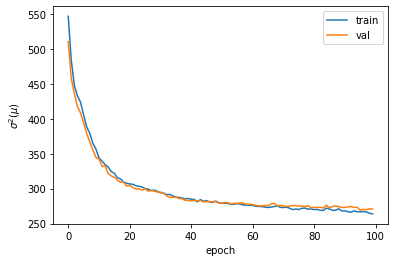

Loss function of BCE


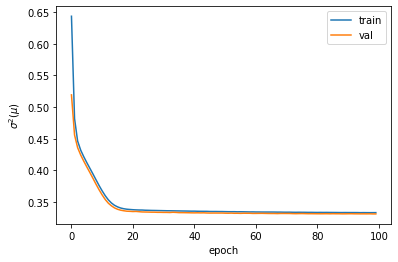

In [ ]:
#Second part : extraction of values from INFERNO and from BCE with data sample c_i

#Part to modify
std_r = 0.2
std_l = 1.4

#Inferno model training
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))  
init_net(net)
model_inf = ModelWrapper(net)
lt_inf = LossTracker()
model_inf.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=None, 
              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,std_r), Normal(0,std_l)], nonaux_b_norm=False),
              lt_inf,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


#BCE model training
net2 = nn.Sequential(nn.Linear(3,100),   nn.ReLU(),
                     nn.Linear(100,100), nn.ReLU(),
                     nn.Linear(100,1),   nn.Sigmoid())
init_net(net2)
lt_bce = LossTracker()
model_bce = ModelWrapper(net2)
model_bce.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=nn.BCELoss(), 
              cbs=[lt_bce,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


mu_scan = torch.linspace(20,80,61)
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]


#The changes in inference
r_vals = [0. - std_r, 0.,  0. + std_r]    
l_vals = [3. - std_l, 3., 3. + std_l]     
nll_inf = compute_nll(model_inf, True ,  r_vals = r_vals, l_vals = l_vals)
nll_bce = compute_nll(model_bce, False, r_vals = r_vals, l_vals = l_vals)



# Get best fit value for mu
mu_best_inf = get_best_fit(nll_inf, mu_scan)
mu_best_bce = get_best_fit(nll_bce, mu_scan)

# Minimize NLL at best fit value
nll_i, param_val_i = best_fit_values(mu_best_inf, model_inf, True, r_vals=r_vals, l_vals =l_vals)
nll_b, param_val_b = best_fit_values(mu_best_bce, model_bce, False, r_vals=r_vals, l_vals =l_vals)
param_df_i = pd.DataFrame(param_val_i)
param_df_b = pd.DataFrame(param_val_b)

# Print cov matrix for last step of optimization
#Inferno
alpha_post_i = param_df_i.iloc[-1]["alpha"]
cov_post_i = param_df_i.iloc[-1]["cov"]
corr_post_i = correlation_from_covariance(cov_post_i)
print('INFERNO')
print(alpha_post_i)
print(cov_post_i,'\n')
print(corr_post_i, '\n')

#Bce
alpha_post_b = param_df_b.iloc[-1]["alpha"]
cov_post_b = param_df_b.iloc[-1]["cov"]
corr_post_b = correlation_from_covariance(cov_post_b)
print('BCE')
print(alpha_post_b)
print(cov_post_b,'\n')
print(corr_post_b, '\n')

#Plot loss
print('Loss function of INFERNO')
plot_loss(lt_inf)
print('Loss function of BCE')
plot_loss(lt_bce)

## Risoluzione Obiettivo 2

In [ ]:
#First part : definition of useful functions
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install torch==1.9.0 fastcore==1.3.20 pytorch_inferno==0.2.2')

from pytorch_inferno.data import get_paper_data
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.inferno import VariableSoftmax, PaperInferno
from torch import nn, optim
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
from fastcore.all import partialler
from torch.distributions import Normal
from pytorch_inferno.inferno import InfernoPred
from pytorch_inferno.inference import bin_preds, get_shape, get_paper_syst_shapes, calc_profile
from pytorch_inferno.plotting import plot_likelihood, plot_preds
from pytorch_inferno.callback import PredHandler
import pandas as pd
import numpy as np
import torch
from torch import Tensor
import matplotlib.pyplot as plt 
from pytorch_inferno.inference import calc_nll, calc_grad_hesse
from typing import Optional, Union, List, Dict
from torch.distributions import Distribution



def compute_nll(model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    #plot_preds(df, bin_edges=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)

    nll = calc_profile(f_s_nom=f_s, **b_shapes, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll

#Plot of loss
def plot_loss(lt):
    
    plt.plot(lt.losses["trn"], label="train")
    plt.plot(lt.losses["val"], label="val")
    plt.ylabel(r"$\sigma^2(\mu)$")
    plt.xlabel(r"epoch")
    plt.legend(loc="upper right")
    plt.show()


    
def newton_optimizer(mu_best:float, f_s_nom:Tensor, f_b_nom:Tensor, n_obs:int, mu_true:int,
                 f_s_up:Optional[Tensor]=None, f_s_dw:Optional[Tensor]=None,
                 f_b_up:Optional[Tensor]=None, f_b_dw:Optional[Tensor]=None,
                 shape_aux:Optional[List[Distribution]]=None,
                 s_norm_aux:Optional[List[Distribution]]=None, b_norm_aux:Optional[List[Distribution]]=None, nonaux_b_norm:bool=False,
                 n_steps:int=100, lr:float=0.1,  verbose:bool=True) -> Tensor:

    r'''Compute profile likelihoods for best mu value, optimising on full hessian.'''
    for f in [f_s_nom, f_s_up, f_s_dw, f_b_nom, f_b_up, f_b_dw]:  # Ensure correct dimensions
        if f is not None and len(f.shape) < 2: f.unsqueeze_(0)
    # Cases where nuisance only causes up xor down variation
    if (f_s_up is None and f_s_dw is not None): f_s_up = torch.repeat_interleave(f_s_nom, repeats=len(f_s_dw), dim=0)
    if (f_s_dw is None and f_s_up is not None): f_s_dw = torch.repeat_interleave(f_s_nom, repeats=len(f_s_up), dim=0)
    if (f_b_up is None and f_b_dw is not None): f_b_up = torch.repeat_interleave(f_s_nom, repeats=len(f_b_dw), dim=0)
    if (f_b_dw is None and f_b_up is not None): f_b_dw = torch.repeat_interleave(f_s_nom, repeats=len(f_b_up), dim=0)
    if f_s_up is not None and f_b_up is not None and len(f_s_up) != len(f_b_up):
        raise ValueError("Shape variations for signal & background must have the same number of variations. \
                          Please enter the nominal templates for nuisances that only affect either signal of background.")
    # Norm uncertainties
    if s_norm_aux is None: s_norm_aux = []
    if b_norm_aux is None: b_norm_aux = []
    # Compute nuisance indeces
    poi_idx = 0
    n_alpha = 1 + np.max((len(f_b_up) if f_b_up is not None else 0, len(f_s_up) if f_s_up is not None else 0))
    shape_idxs = list(range(1,n_alpha))
    print("shape_idxs", shape_idxs)
    s_norm_idxs = list(range(n_alpha, n_alpha+len(s_norm_aux)))
    n_alpha += len(s_norm_aux)
    b_norm_idxs = list(range(n_alpha, n_alpha+len(b_norm_aux)+nonaux_b_norm))
    n_alpha += len(b_norm_aux)+nonaux_b_norm

    b_true = n_obs-mu_true

    get_nll = partialler(calc_nll, s_true=mu_true, b_true=b_true,
                        f_s_nom=f_s_nom, f_s_up=f_s_up, f_s_dw=f_s_dw,
                        f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw,
                        s_norm_aux=s_norm_aux, b_norm_aux=b_norm_aux, shape_aux=shape_aux)
    
    # Initialize the parameters
    alpha = torch.zeros((n_alpha), requires_grad=True, device=f_b_nom.device)
    #mu = torch.tensor(mu_best)#.to(f_b_nom.device)
    with torch.no_grad(): alpha[poi_idx] = mu_best

    print("alpha", alpha)

    # List to store relevant info
    param_val = []

    # print("Mu", mu)
    for i in range(n_steps):  # Newton optimise nuisances
        nll = get_nll(shape_alpha=alpha[shape_idxs], mu=alpha[poi_idx], s_norm_alpha=alpha[s_norm_idxs], b_norm_alpha=alpha[b_norm_idxs])
        #print("nll", nll)
        grad, hesse = calc_grad_hesse(nll, alpha, create_graph=False)
        #print("grad", grad)
        #print("hesse", hesse)
        # Step is learning rate * gradient * covariance matrix 
        cov = torch.inverse(hesse)
        step = lr*grad.detach()@cov
        #print("step", step)
        # Avoid too large steps
        step = torch.clamp(step, -100, 100)
        # Apply the step to the parameters
        alpha = alpha-step
        print("alpha", alpha)
        # Store the parameter infos
        param_val.append({ 'step':i, 'alpha':alpha.detach().numpy(), 'cov':cov.detach().numpy() })

    # Last nll evaluation
    nll = get_nll(shape_alpha=alpha[shape_idxs], mu=alpha[poi_idx], s_norm_alpha=alpha[s_norm_idxs], b_norm_alpha=alpha[b_norm_idxs]).detach()
    return nll, param_val 

def best_fit_values(mu_best:float, model:ModelWrapper, is_inferno:bool,r_vals=[-0.2,0,0.2],l_vals=[2.5,3,3.5]) -> Tensor:  
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, r_vals = r_vals, l_vals = l_vals, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)
    nll, param_val = newton_optimizer(mu_best=mu_best, f_s_nom=f_s, **b_shapes, n_obs=1050, mu_true=50, n_steps=100, shape_aux=[Normal(0,1), Normal(0,1)])
    return nll, param_val
    
def get_best_fit(nll, mu_scan):
    return mu_scan[np.argmin(nll)]

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [ ]:
#!! Da fare per salvare ed importare il dataset !!

#Creo un unico dataset che userò per fare le 5 implementazioni per ciascuno dei 5 casi e lo salvo per poterlo recuretare quando esco dalla sessione
import numpy as np
from pytorch_inferno.data import *
from pytorch_inferno.data import get_paper_data

from google.colab import drive

def save_array(dl, name):
    np.save(name + '_x.npy', dl.dataset.x)
    np.save(name + '_y.npy', dl.dataset.y)
    
def load_array(name):
    x = np.load(name + '_x.npy')
    y = np.load(name + '_y.npy')
    return x, y

def save_dl(data, test, prefix="dataset0"):
    save_array(data.trn_dl, prefix + "_train")
    save_array(data.val_dl, prefix + "_validation")
    save_array(test, prefix + "_test")
  
def reinit_dl(bs=2000, prefix="dataset0"):
    x_train, y_train = load_array(prefix + "_train")
    x_val, y_val = load_array(prefix + "_validation")
    x_test, y_test = load_array(prefix + "_test")
    trn_dl = WeightedDataLoader(DataSet(x_train, y_train), batch_size=bs, shuffle=True, drop_last=True)
    val_dl = WeightedDataLoader(DataSet(x_val, y_val), batch_size=2*bs, shuffle=True)
    data = DataPair(trn_dl, val_dl)
    tst_dl = WeightedDataLoader(DataSet(x_test, y_test), batch_size=2*bs)
    return data, tst_dl





In [ ]:
#Da fare una volta
#Salvare il dataset
drive.mount('/content/gdrive')
data, test = get_paper_data(200000, bs=2000, n_test=1000000)

# Save arrays
save_dl(data, test, prefix="/content/gdrive/MyDrive/dataset0")

Mounted at /content/gdrive


In [ ]:
# Load the arrays again and reinitialize the dataloaders
drive.mount('/content/gdrive')
data, test = reinit_dl(prefix="/content/gdrive/MyDrive/dataset0")

Mounted at /content/gdrive


Run number: 1


1: Train=712.9744857788086 Valid=600.1834857177735
2: Train=562.2293701171875 Valid=529.6893182373046
3: Train=502.8896026611328 Valid=486.3245184326172
4: Train=466.86830444335936 Valid=461.13525024414065
5: Train=441.4096926879883 Valid=435.1174841308594
6: Train=427.426875 Valid=423.7398840332031
7: Train=409.93147705078127 Valid=404.91967407226565
8: Train=393.4904260253906 Valid=393.7964483642578
9: Train=381.14570281982424 Valid=379.35045532226565
10: Train=369.01134185791017 Valid=372.03247436523435
11: Train=360.9691278076172 Valid=359.85713745117187
12: Train=354.63779388427736 Valid=356.9600354003906
13: Train=346.9736489868164 Valid=346.3449407958984
14: Train=339.7892321777344 Valid=341.00768615722654
15: Train=332.46300094604493 Valid=332.2831756591797
16: Train=324.3808850097656 Valid=328.0968292236328
17: Train=322.16070861816405 Valid=322.81243408203125
18: Train=319.8588757324219 Valid=320.80168212890624
19: Train=315.5176684570313 Valid=316.302451171875
20: Train=311.

1: Train=0.6960751283168792 Valid=0.5367541146278382
2: Train=0.49282399713993075 Valid=0.4647251296043396
3: Train=0.4526621451973915 Valid=0.4424848473072052
4: Train=0.4366938689351082 Valid=0.43052247285842893
5: Train=0.4261888739466667 Valid=0.4209049665927887
6: Train=0.4166650176048279 Valid=0.4115771216154098
7: Train=0.4071106925606728 Valid=0.4019822156429291
8: Train=0.3975307333469391 Valid=0.392330459356308
9: Train=0.38775487095117567 Valid=0.3824877893924713
10: Train=0.37782348692417145 Valid=0.372408350110054
11: Train=0.3679022005200386 Valid=0.36296780705451964
12: Train=0.35909617781639097 Valid=0.3550443649291992
13: Train=0.35204744458198545 Valid=0.3488059467077255
14: Train=0.346587230861187 Valid=0.3444173115491867
15: Train=0.34292654871940614 Valid=0.3418146765232086
16: Train=0.3408891114592552 Valid=0.3401612210273743
17: Train=0.33949574440717695 Valid=0.3392127299308777
18: Train=0.33869476228952405 Valid=0.338715146780014
19: Train=0.338221438229084 Val

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=2.2


Running: l=3.0


Running: l=3.8


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=2.2


Running: l=3.0


Running: l=3.8


Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=2.2


Running: l=3.0


Running: l=3.8


shape_idxs [1, 2]
alpha tensor([50.,  0.,  0.], requires_grad=True)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([

Running: r=-0.2


Running: r=0.0


Running: r=0.2


Running: l=2.2


Running: l=3.0


Running: l=3.8


shape_idxs [1, 2]
alpha tensor([50.,  0.,  0.], requires_grad=True)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([50.,  0.,  0.], grad_fn=<SubBackward0>)
alpha tensor([

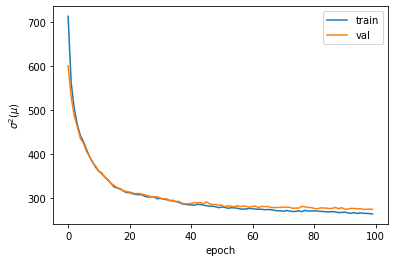

Loss function of BCE


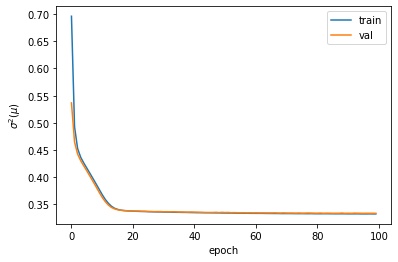

Run number: 2


KeyboardInterrupt: ignored

In [ ]:
#Second part : eseguo questa cella una volta per ogni caso, e mi restituisce gli esiti di 5 run sullo stesso dataset
#extraction of values from INFERNO and from BCE with data sample c_i
#da svolgere 5 volte per ogni caso

#Part to modify
std_r = 0.2
std_l = 0.8

for i in range(5): 
  print('Run number:', i+1)
  
  #Inferno model training
  net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                      nn.Linear(100,100),nn.ReLU(),
                      nn.Linear(100,10), VariableSoftmax(0.1))  
  init_net(net)
  model_inf = ModelWrapper(net)
  lt_inf = LossTracker()
  model_inf.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=None, 
                cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,std_r), Normal(0,std_l)], nonaux_b_norm=False),
                lt_inf,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


  #BCE model training
  net2 = nn.Sequential(nn.Linear(3,100),   nn.ReLU(),
                      nn.Linear(100,100), nn.ReLU(),
                      nn.Linear(100,1),   nn.Sigmoid())
  init_net(net2)
  lt_bce = LossTracker()
  model_bce = ModelWrapper(net2)
  model_bce.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=nn.BCELoss(), 
                cbs=[lt_bce,SaveBest('weights/best_ie.h5'),EarlyStopping(100)])


  mu_scan = torch.linspace(20,80,61)
  bkg = test.dataset.x[test.dataset.y.squeeze() == 0]


  #The changes in inference
  r_vals = [0. - std_r, 0.,  0. + std_r]    
  l_vals = [3. - std_l, 3., 3. + std_l]     
  nll_inf = compute_nll(model_inf, True ,  r_vals = r_vals, l_vals = l_vals)
  nll_bce = compute_nll(model_bce, False, r_vals = r_vals, l_vals = l_vals)



  # Get best fit value for mu
  mu_best_inf = get_best_fit(nll_inf, mu_scan)
  mu_best_bce = get_best_fit(nll_bce, mu_scan)

  # Minimize NLL at best fit value
  nll_i, param_val_i = best_fit_values(mu_best_inf, model_inf, True, r_vals=r_vals, l_vals =l_vals)
  nll_b, param_val_b = best_fit_values(mu_best_bce, model_bce, False, r_vals=r_vals, l_vals =l_vals)
  param_df_i = pd.DataFrame(param_val_i)
  param_df_b = pd.DataFrame(param_val_b)

  # Print cov matrix for last step of optimization
  #Inferno
  alpha_post_i = param_df_i.iloc[-1]["alpha"]
  cov_post_i = param_df_i.iloc[-1]["cov"]
  corr_post_i = correlation_from_covariance(cov_post_i)
  print('INFERNO')
  print(alpha_post_i)
  print(cov_post_i,'\n')
  print(corr_post_i, '\n')

  #Bce
  alpha_post_b = param_df_b.iloc[-1]["alpha"]
  cov_post_b = param_df_b.iloc[-1]["cov"]
  corr_post_b = correlation_from_covariance(cov_post_b)
  print('BCE')
  print(alpha_post_b)
  print(cov_post_b,'\n')
  print(corr_post_b, '\n')

  #Plot loss
  print('Loss function of INFERNO')
  plot_loss(lt_inf)
  print('Loss function of BCE')
  plot_loss(lt_bce)